In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from six.moves import xrange
import umap

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim


from vqvae_utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loader

In [3]:
class customDataset(Dataset):
    def __init__(self, path, transform):
        
        self.path = path
        self.transform = transform
        self.imgs = os.listdir(path)
        
        
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.path, self.imgs[index])).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = -1
        return image, label
        
    def __len__(self):
        return len(self.imgs)

In [4]:
trans = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()])

fgo_train = customDataset(path='data/fgo/train', transform=trans)
fgo_test = customDataset(path='data/fgo/test', transform=trans)

train_loader = DataLoader(dataset=fgo_train, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset=fgo_test, batch_size=15, shuffle=True, num_workers=4, pin_memory=True)

In [4]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest', alpha = 1.0)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

## Model

In [5]:
batch_size = 8
num_training_updates = 10000

num_hiddens = 256
num_residual_hiddens = 128
num_residual_layers = 3

embedding_dim = 128
num_embeddings = 512

commitment_cost = 0.25
decay = 0.99
learning_rate = 1e-3

In [6]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
# model.train()
train_res_recon_error = []
train_res_perplexity = []

test_data, _ = next(iter(test_loader))
test_data = test_data.to(device)

for i in xrange(num_training_updates):
    (data, _) = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()
    
    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) #/ data_variance
    loss = recon_error + vq_loss
    loss.backward()
    
    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    
    if (i+1) % 100 ==0:
        
        _, test_recon, _ = model(test_data)
        test_recon_loss = F.mse_loss(test_recon, test_data).detach().cpu().item()
        
        print('{:d} iterations, recon_error : {:.3f}, perplexity: {:.3f}, test_recon_error : {:.3f}\r\n'.format(i+1, np.mean(train_res_recon_error[-100:]), np.mean(train_res_perplexity[-100:]), test_recon_loss))


In [9]:
PATH='saved_models/vqvae_fgo_params0224.pkl'
torch.save(model.state_dict(), PATH)

## Reconstructions

In [10]:
# model.eval()
(valid_originals, _) = next(iter(test_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [11]:
(train_originals, _) = next(iter(train_loader))
train_originals = train_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(train_originals))
_, train_quantize, _, _ = model._vq_vae(vq_output_eval)
train_reconstructions = model._decoder(train_quantize)

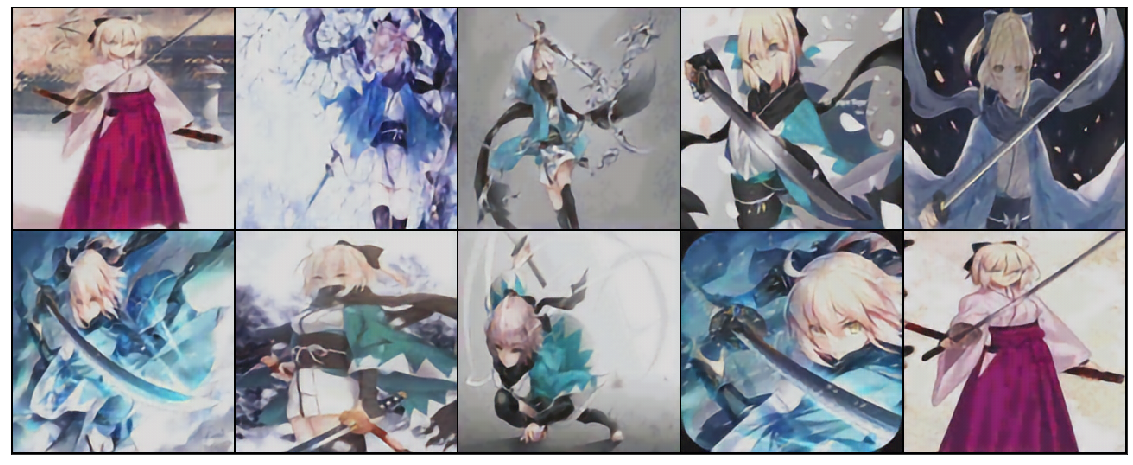

In [12]:
plt.figure(figsize=(20, 10))
show(make_grid(valid_reconstructions.cpu().data[:10,:,:,:], nrow=5, normalize=True))

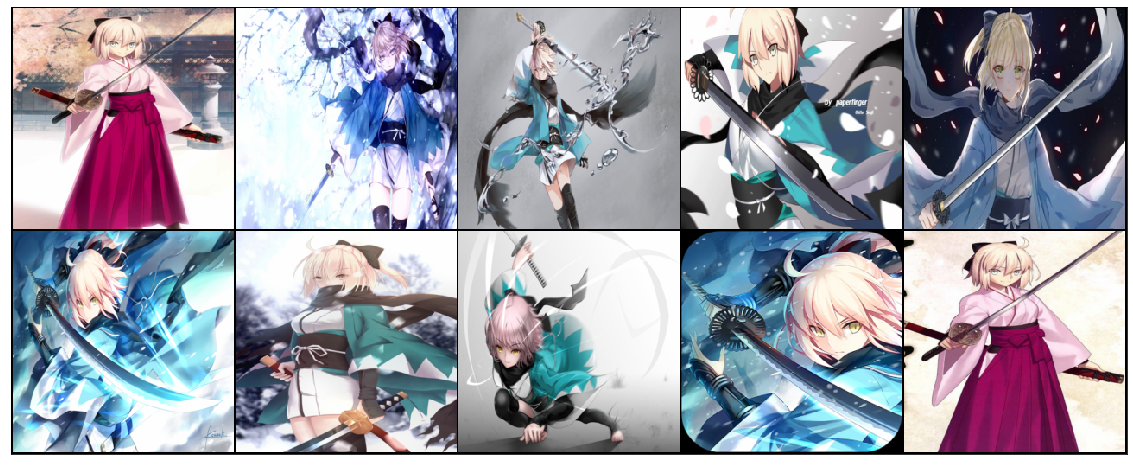

In [13]:
plt.figure(figsize=(20, 10))
show(make_grid(valid_originals.cpu()[:10,:,:,:], nrow=5, normalize=True))

## View Embedding

In [14]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

/home/jovyan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 14 separate connected components using meta-embedding (experimental)
  n_components


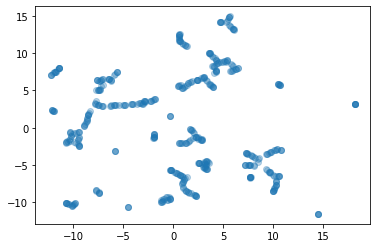

In [15]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

## Reconstruction image with other style

In [8]:
model.load_state_dict(torch.load('saved_models/vqvae_fgo_params0224.pkl'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
trans = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()])

fgo_test = customDataset(path='data/test_img', transform=trans)
test_loader = DataLoader(dataset=fgo_test, batch_size=15, shuffle=True, num_workers=4, pin_memory=True)

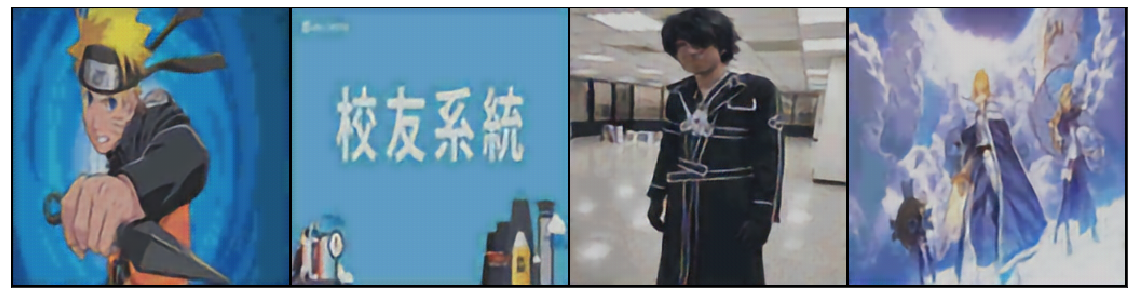

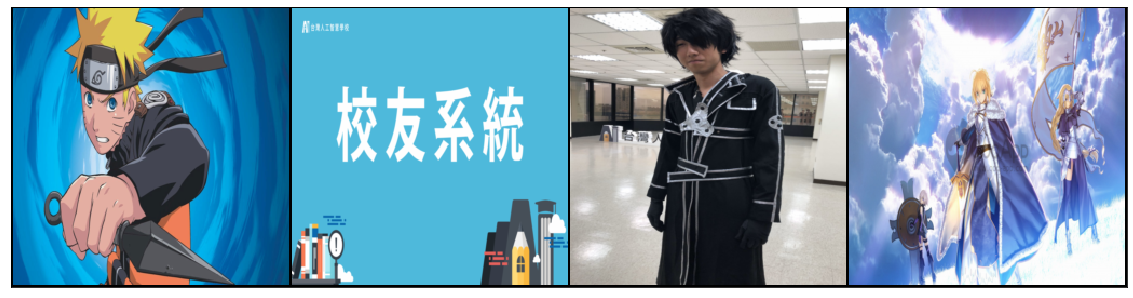

In [18]:
# model.eval()
(valid_originals, _) = next(iter(test_loader))
valid_originals = valid_originals.to(device)

_, valid_reconstructions, _ = model(valid_originals)

plt.figure(figsize=(20, 10))
show(make_grid(valid_reconstructions.cpu().data, nrow=5, normalize=True))

plt.figure(figsize=(20, 10))
show(make_grid(valid_originals.cpu(), nrow=5, normalize=True))